# Check hint effects on homework

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
from pandas import DataFrame
from collections import defaultdict
import scipy.stats as stats
import numpy as np

## Load Data

In [2]:
hint_feature_df = pd.read_pickle("../data/pkl_data/hint_feature_df.pkl")
hint_feature_df.head(3)

,"(7, 6, hint_count)","(4, 4, hint_count)","(8, 3, hint_count)","(5, 5, hint_count)","(7, 2, hint_count)","(4, 1, hint_count)","(8, 4, hint_count)","(7, 5, hint_count)","(4, 5, hint_count)","(5, 4, hint_count)",...,"(8, 2, time_spent)","(6, 6, time_spent)","(3, 1, time_spent)","(7, 3, time_spent)","(2, 12, time_spent)","(6, 5, time_spent)","(6, 4, time_spent)","(3, 5, time_spent)","(6, 3, time_spent)","(5, 1, time_spent)"
ID,,,,,,,,,,,,,,,,,,,,,
247,0,0,1,0,0,0,0,0,0,0,...,0,1160,0,3684,0,1044,0,0,6345,3444
336,0,0,0,3,0,0,0,0,0,0,...,0,960,268,0,0,0,177,0,8185,992
109,0,4,0,0,0,0,0,0,4,0,...,0,292,0,0,0,0,363,35,0,1867


In [3]:
cols = [c for c in hint_feature_df.columns if len(c) == 3 and c[2] == 'hint_count']
hint_feature_df.sum()[cols].sum()

2859

In [4]:
hw_df = pd.read_pickle('../data/pkl_data/hw_data.pkl')
problem_list = sorted(list(set([(c[0],c[1]) for c in hw_df.columns if len(c)==3])))
hw_df.head(1)

,"(2, 10, 1)","(2, 10, 2)","(2, 10, 3)","(2, 10, 4)","(2, 11, 1)","(2, 11, 2)","(2, 12, 1)","(2, 12, 2)","(2, 12, 3)","(2, 12, 4)",...,"(8, 3, 1)","(8, 3, 2)","(8, 3, 3)","(8, 3, 4)","(8, 4, 1)","(8, 4, 2)","(8, 4, 3)","(8, 5, 1)","(8, 5, 2)","(8, 6, 1)"
ID,,,,,,,,,,,,,,,,,,,,,
247,"[[2016-10-04 01:07:43, 1/12, 1, null]]","[[2016-10-04 01:07:43, 5/6, 1, null]]","[[2016-10-04 01:07:43, 1/12, 1, null]]","[[2016-10-04 01:07:43, 1, 1, null]]","[[2016-10-04 01:08:00, 4, 1, null]]","[[2016-10-04 01:08:00, 1/13, 1, null]]","[[2016-10-04 01:11:02, 1024, 1, null], [2016-1...","[[2016-10-04 01:11:02, 1/1024, 1, null], [2016...","[[2016-10-04 01:11:02, 10, 1, null], [2016-10-...","[[2016-10-04 01:11:02, 1/512, 0, null], [2016-...",...,"[[2016-11-17 01:10:21, 400, 0, 400/64], [2016-...","[[2016-11-17 01:19:27, (e^(-400/81))*((400/81)...","[[2016-11-17 01:19:27, (e^(-400/81))*((400/81)...","[[2016-11-17 00:22:58, 1-e^(-150), Please fin...","[[2016-11-17 02:01:33, 1/10, 1, 80.0*1/800.0],...","[[2016-11-17 02:01:33, (e^-(1/10))*((1/10)^2/(...","[[2016-11-17 02:01:33, 1-e^(-(1/10)*(1/10)), 0...","[[2016-11-17 02:22:33, (1/6.5)e^(-6.5*9), 0, e...","[[2016-11-17 03:20:07, e^(-(10/5.5))*(((10/5.5...","[[2016-11-17 02:33:13, e^(-2.1), 0, ((1/2) * e..."


## Find Downstream Problems

In [5]:
def get_downstream_problems(hw_df, hint_df):
    """ Find the problems after the first hint problem for each student in each assignment """
    studentID_list = hint_df.index.tolist()
    after_first_pros = {}
    for ind, row in hw_df.iterrows():
        if not ind in studentID_list:
            continue
        assign_after_first = defaultdict(str)
        pro_finish_time = {}
        col_count = 0
        hint_times = {}
        hint_pros = {}
        no_hint_pros = []
        row = row.fillna(-111)
        cols = row.index.tolist()
        for r in row:
            title = cols[col_count]
            if int(title[0]) < 4 or r == -111:
                col_count += 1
                continue
            if type(r) is int:
                print r
            pro_finish_time[title] = pd.to_datetime(r[-1][0])
            pro_hint_time = [pd.to_datetime(t[0]) for t in r if t[-1] == "Hint"]
            if pro_hint_time:
                first_pro_hint_time = min(pro_hint_time)
                if title[0] not in hint_times.keys():
                    hint_times[title[0]] = first_pro_hint_time
                    hint_pros[title[0]] = title[1]
                elif hint_times[title[0]] > first_pro_hint_time:
                    hint_times[title[0]] = first_pro_hint_time
                    hint_pros[title[0]] = title[1]
            else:
                no_hint_pros.append(title)
            col_count += 1
        
        if hint_times:
            for c in cols:
                if int(c[0]) < 4:
                    continue
                if c[0] in hint_times.keys()\
                and c in pro_finish_time\
                and pro_finish_time[c] > hint_times[c[0]]\
                and c in no_hint_pros\
                and c[1] != hint_pros[c[0]]:
                    if not assign_after_first[c[0]]:
                        assign_after_first[c[0]] = [c[1]]
                    elif c[1] not in assign_after_first[c[0]]:
                        assign_after_first[c[0]].append(c[1])
        after_first_pros[ind] = assign_after_first
    return after_first_pros

downstream_problems = get_downstream_problems(hw_df, hint_feature_df)

## Statistical Analysis

In [6]:
def ttest(control_feature, case_feature, problem_list):
    """
    perform t-test
    """
    control_mean = []
    case_mean = []
    problems = []
    p_vals = defaultdict(float)
    for prob in problem_list:
        if int(prob[0]) < 4:
            continue
        control = control_feature[prob]
        case = case_feature[prob]
        diff = np.mean(control)-np.mean(case)
        if control and case and diff and np.std(control) and np.std(case):
            stat_values = stats.ttest_ind(control, case)
            problems.append(prob)
            control_mean.append(np.mean(control))
            case_mean.append(np.mean(case))
            p_vals[prob] = stat_values[1]

            #print "{0} & {1:.3f} & {2:.3f} & {3:.3f} & {4:.3f} ".format(len(case_pro), np.mean(case_pro)/60., np.std(case_pro)/60., stat_values[1], diff/60.)
            print prob
            print "control (size/mean/std):", len(control), np.mean(control), np.std(control)
            print "case (size/mean/std):", len(case), np.mean(case), np.std(case)
            print stat_values, '\n'
    return problems, control_mean, case_mean, p_vals

## Plot Functions

In [67]:
from pylab import plot, show, savefig, xlim, figure, \
                hold, ylim, legend, boxplot, setp, axes
from math import log10, floor

def fig_setting(base_size):
    SMALL_SIZE = base_size
    MEDIUM_SIZE = base_size+2
    BIGGER_SIZE = base_size+4
    plt.figure(figsize=(15,20))
    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    return plt

def setBoxColors(bp):
    setp(bp['boxes'][0], color='blue')
    setp(bp['caps'][0], color='blue')
    setp(bp['caps'][1], color='blue')
    setp(bp['whiskers'][0], color='blue')
    setp(bp['whiskers'][1], color='blue')
    setp(bp['fliers'][0], color='blue')
    setp(bp['medians'][0], color='blue')

    setp(bp['boxes'][1], color='red')
    setp(bp['caps'][2], color='red')
    setp(bp['caps'][3], color='red')
    setp(bp['whiskers'][2], color='red')
    setp(bp['whiskers'][3], color='red')
    setp(bp['fliers'][1], color='red')
    setp(bp['medians'][1], color='red')
    
def box_plots(problems, p_vals, control_fea, case_fea, title, xlabel, xmax):
    fig = fig_setting(16)
    fig.figure(figsize=(10,15))
    ax = axes()
    hold(True)

    pros = []
    m = 0
    for p in problems:
        if int(p[0]) < 4 or int(p[0])>7:
            continue
        pv = p_vals[p]
        if pv:
            if pv > 0.01:
                pv = round(pv, 2)
            elif pv > 0.001:
                pv = round(pv, 3)
            elif pv > 0.0001:
                pv = round(pv, 4)
            else:
                pv = '10'+str(pv)[str(pv).index('e')+1:]
            bp = boxplot([control_fea[p], case_fea[p]], positions = [m*3+1, m*3+2], widths = 0.8, vert=False)
            setBoxColors(bp)
            pros.append('({0},{1}), {2}'.format(p[0], p[1], pv))
        else:
            bp = boxplot([[],[]], positions = [m*3+1, m*3+2], widths = 0.6, vert=False)
            setBoxColors(bp)
            pros.append('({0},{1})'.format(p[0], p[1]))
        m += 1

    # set axes limits and labels
    ylim(0,len(pros)*3)
    xlim(0,xmax)
    ax.set_yticks(np.array(range(15, 15*len(pros)*2, 30))/10.)
    ax.set_yticklabels(pros)#, rotation='vertical')
    ax.set_title(title)
    ax.set_ylabel('Problem ID, P-Values')
    ax.set_xlabel(xlabel)

    # draw temporary red and blue lines and use them to create a legend
    hB, = plot([1,1],'b-')
    hR, = plot([1,1],'r-')
    legend((hB, hR),('Control', 'Case'), loc=1)
    hB.set_visible(False)
    hR.set_visible(False)
    fig.tight_layout()


## Filter functions
* statistial analysis per problem
* statistial analysis per assignment
* statistial analysis per assignment with control average

### 1. analysis per downstream problem
* For each problem, find the number of tries(length of time) for control and case.
* Control and case could be of different size.

In [68]:
def feature_per_downstream_problem(df, feature, problem_list, downstream_problems, all_control=True):
    """
    For each problem, find the number of tries(length of time) for control and case
    If [all_control] is false, only look at control students who has at least 1 hint sent.
    """
    ### for each problem find the control and case features in the format of {pro_id:[feature list]}
    control_feature = defaultdict(list)
    case_feature = defaultdict(list)

    for student_id, row in df.iterrows(): # each student
        for prob in problem_list: # each problem
            if int(prob[0]) < 4 or int(prob[0]) > 7: # Skip assignment 1, 2, and 3
                continue
            h_count_key = (prob[0], prob[1], 'hint_count')
            assign_key = (prob[0],'assign')
            feature_key = (prob[0],prob[1],feature)
            prob_key = (prob[0], prob[1])
        
            if row[feature_key]:
                if all_control:
                    if row[assign_key] == '0': # control group
                        control_feature[prob].append(row[feature_key])
                else:
                    if row[assign_key] == '0' and row[h_count_key] > 0: #control group and with hints sent
                        control_feature[prob].append(row[feature_key])
                if row[assign_key] == '1' and row[h_count_key] == 0: # case group
                    downstream = downstream_problems[student_id][prob[0]]
                    if downstream: # has hints in assignment prob[0]
                        if prob[1] in downstream and row[h_count_key] == 0: # prob[1] is in downstream problems
                            case_feature[prob].append(row[feature_key])
            
    return control_feature, case_feature

In [79]:
### Find number of tries per problem
control_feature, case_feature = feature_per_downstream_problem(hint_feature_df, "tries", problem_list, downstream_problems, all_control = False)
try_pros, try_control, try_case, try_p_vals = ttest(control_feature, case_feature, problem_list)

('4', '2')
control (size/mean/std): 10 30.0 15.3687995628
case (size/mean/std): 9 15.7777777778 9.11382073529
Ttest_indResult(statistic=2.2886912801189148, pvalue=0.035171519272497474) 

('4', '4')
control (size/mean/std): 8 9.75 3.07205143186
case (size/mean/std): 15 5.53333333333 3.3038697849
Ttest_indResult(statistic=2.8536110458705948, pvalue=0.0095112478417687246) 

('4', '5')
control (size/mean/std): 35 20.2 11.7711511756
case (size/mean/std): 8 9.25 5.58457697592
Ttest_indResult(statistic=2.5055557521523051, pvalue=0.016290180426707389) 

('4', '7')
control (size/mean/std): 4 22.25 16.4829457319
case (size/mean/std): 37 9.40540540541 6.71609385935
Ttest_indResult(statistic=2.9032077557694453, pvalue=0.0060501778227495797) 

('4', '9')
control (size/mean/std): 19 27.0 15.3725661317
case (size/mean/std): 29 18.1379310345 12.4588263629
Ttest_indResult(statistic=2.1476049527898349, pvalue=0.037047403735531982) 

('5', '1')
control (size/mean/std): 62 49.5967741935 45.2528593563
case

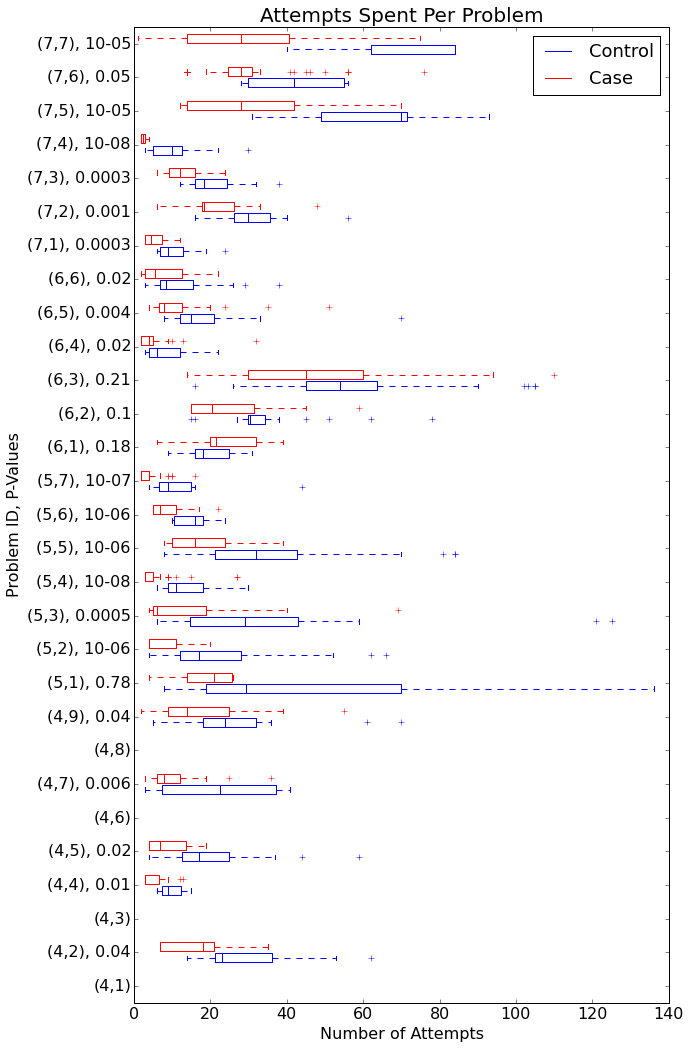

In [80]:
### Plot box plots
box_plots(problem_list, try_p_vals, control_feature, case_feature, 'Attempts Spent Per Problem', 'Number of Attempts', 140)
savefig('../graphs/problem_tries_downstream.png')

In [81]:
### Find length of time per problem
control_feature, case_feature = feature_per_downstream_problem(hint_feature_df, "time_spent", problem_list, downstream_problems, all_control = False)
time_pros, time_control, time_case, time_p_vals = ttest(control_feature, case_feature, problem_list)

('4', '2')
control (size/mean/std): 10 4099.6 3802.47370011
case (size/mean/std): 4 4138.25 1521.82495298
Ttest_indResult(statistic=-0.018245455644557783, pvalue=0.98574289799801884) 

('4', '4')
control (size/mean/std): 8 795.125 198.800425993
case (size/mean/std): 6 706.833333333 513.741963981
Ttest_indResult(statistic=0.41088267662223671, pvalue=0.68840083337319791) 

('4', '5')
control (size/mean/std): 35 2237.77142857 1738.0339317
case (size/mean/std): 5 815.4 585.849673551
Ttest_indResult(statistic=1.7693153855587562, pvalue=0.084866674053033886) 

('4', '7')
control (size/mean/std): 4 2545.25 2294.89611693
case (size/mean/std): 28 1163.64285714 1251.02795487
Ttest_indResult(statistic=1.7575044186144491, pvalue=0.089033628614246463) 

('4', '9')
control (size/mean/std): 19 3129.52631579 2339.82865698
case (size/mean/std): 22 2581.90909091 2224.773102
Ttest_indResult(statistic=0.74835011515099104, pvalue=0.45873843903498135) 

('5', '1')
control (size/mean/std): 62 3129.64516129 2

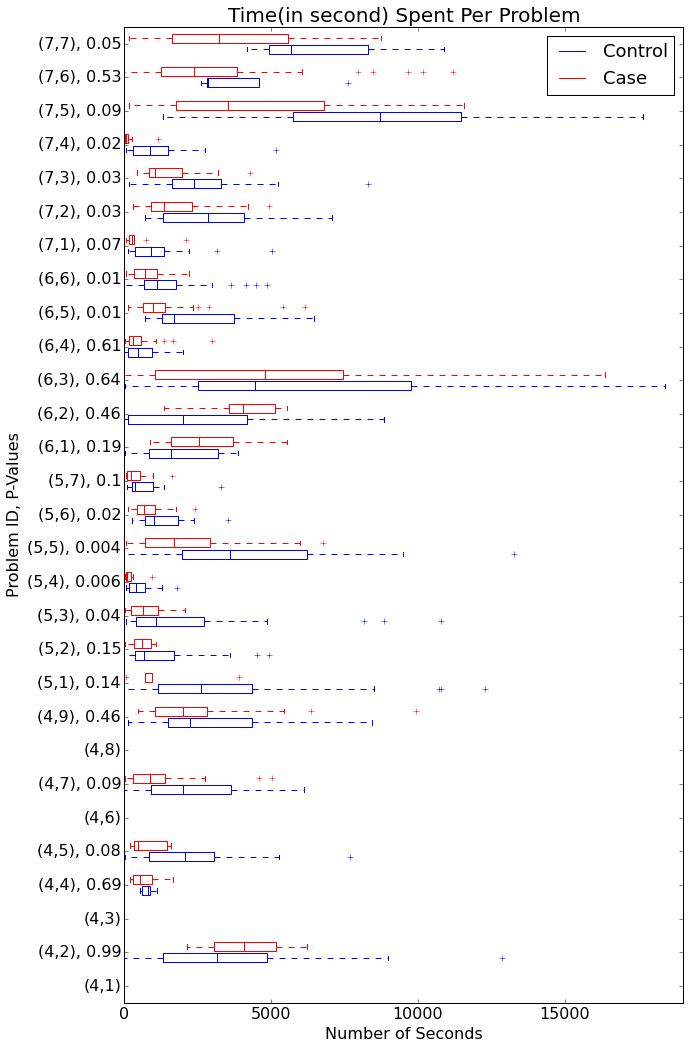

In [82]:
### Plot box plots
box_plots(problem_list, time_p_vals, control_feature, case_feature, 'Time(in second) Spent Per Problem', 'Number of Seconds', 19000)
savefig('../graphs/problem_time_downstream.png')

### 2. analysis per problem with hint

In [73]:
def feature_per_problem(df, feature, problem_list, all_control=True):
    """
    For each problem, find the number of tries(length of time) for control and case
    If [all_control] is false, only look at control students who has at least 1 hint sent.
    """
    ### for each problem find the control and case features in the format of {pro_id:[feature list]}
    control_feature = defaultdict(list)
    case_feature = defaultdict(list)

    for student_id, row in df.iterrows(): # each student
        for prob in problem_list: # each problem
            if int(prob[0]) < 4 or int(prob[0]) > 7: # Skip assignment 1, 2, and 3
                continue
            h_count_key = (prob[0], prob[1], 'hint_count')
            assign_key = (prob[0],'assign')
            feature_key = (prob[0],prob[1],feature)
            prob_key = (prob[0], prob[1])
        
            if row[feature_key]:
                if all_control:
                    if row[assign_key] == '0': # control group
                        control_feature[prob].append(row[feature_key])
                else:
                    if row[assign_key] == '0' and row[h_count_key] > 0: #control group and with hints sent
                        control_feature[prob].append(row[feature_key])
                if row[assign_key] == '1' and row[h_count_key] > 0: # case group 
                    case_feature[prob].append(row[feature_key])
            
    return control_feature, case_feature

In [74]:
### Find number of tries per problem
control_feature, case_feature = feature_per_problem(hint_feature_df, "tries", problem_list, all_control = False)
try_pros, try_control, try_case, try_p_vals = ttest(control_feature, case_feature, problem_list)

('4', '1')
control (size/mean/std): 3 9.33333333333 2.49443825785
case (size/mean/std): 9 21.1111111111 10.1810766124
Ttest_indResult(statistic=-1.8110796065963635, pvalue=0.10022563967585627) 

('4', '2')
control (size/mean/std): 10 30.0 15.3687995628
case (size/mean/std): 10 22.2 8.69252552484
Ttest_indResult(statistic=1.3252739487596406, pvalue=0.20165723527065349) 

('4', '4')
control (size/mean/std): 8 9.75 3.07205143186
case (size/mean/std): 4 7.0 1.22474487139
Ttest_indResult(statistic=1.5730345284868545, pvalue=0.14678652032354911) 

('4', '5')
control (size/mean/std): 35 20.2 11.7711511756
case (size/mean/std): 27 20.5925925926 15.4590480739
Ttest_indResult(statistic=-0.11167548755975223, pvalue=0.91145347574151159) 

('4', '7')
control (size/mean/std): 4 22.25 16.4829457319
case (size/mean/std): 2 13.5 4.5
Ttest_indResult(statistic=0.60186251419321757, pvalue=0.57971573390126174) 

('4', '9')
control (size/mean/std): 19 27.0 15.3725661317
case (size/mean/std): 15 26.666666666

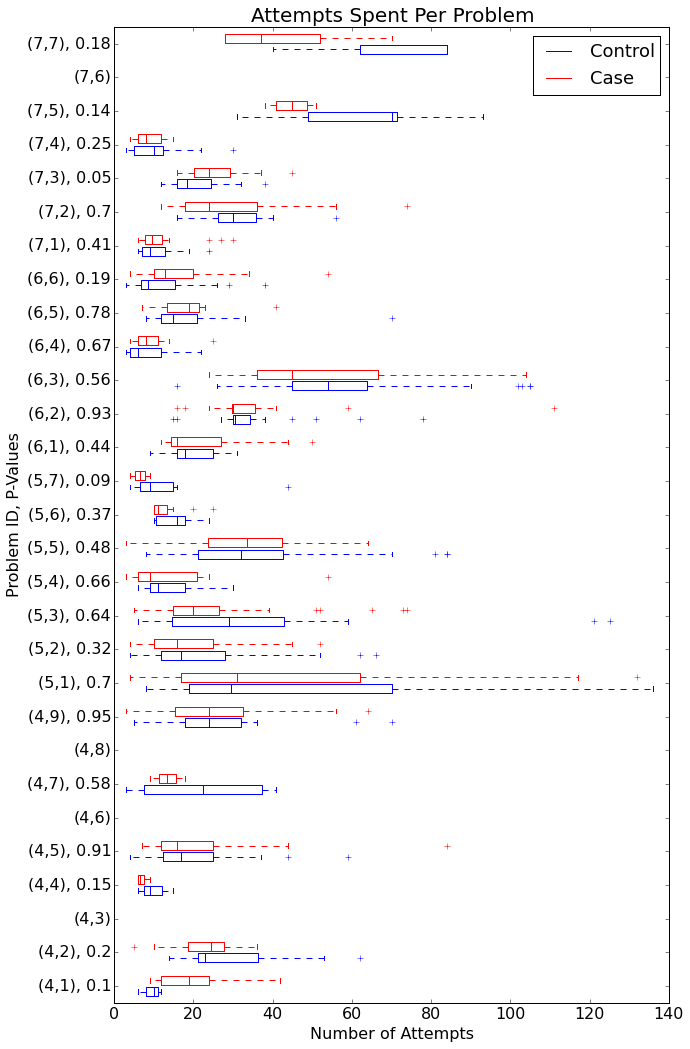

In [76]:
### Plot box plots
box_plots(problem_list, try_p_vals, control_feature, case_feature, 'Attempts Spent Per Problem', 'Number of Attempts', 140)
savefig('../graphs/problem_tries.png')

In [77]:
### Find length of time per problem
control_feature, case_feature = feature_per_problem(hint_feature_df, "time_spent", problem_list, all_control = False)
time_pros, time_control, time_case, time_p_vals = ttest(control_feature, case_feature, problem_list)

('4', '1')
control (size/mean/std): 3 792.0 513.15494736
case (size/mean/std): 9 1663.11111111 892.365949403
Ttest_indResult(statistic=-1.4648548207207748, pvalue=0.17367979064726752) 

('4', '2')
control (size/mean/std): 10 4099.6 3802.47370011
case (size/mean/std): 10 2148.3 1696.98768705
Ttest_indResult(statistic=1.405848811211595, pvalue=0.17679629109140543) 

('4', '4')
control (size/mean/std): 8 795.125 198.800425993
case (size/mean/std): 4 176.75 139.209150202
Ttest_indResult(statistic=5.0893146774998099, pvalue=0.00047132450186415794) 

('4', '5')
control (size/mean/std): 35 2237.77142857 1738.0339317
case (size/mean/std): 26 1864.92307692 1547.357572
Ttest_indResult(statistic=0.85346690321066554, pvalue=0.39685223313532203) 

('4', '7')
control (size/mean/std): 4 2545.25 2294.89611693
case (size/mean/std): 2 1167.0 117.0
Ttest_indResult(statistic=0.69303044411453141, pvalue=0.52642641319144734) 

('4', '9')
control (size/mean/std): 19 3129.52631579 2339.82865698
case (size/mea

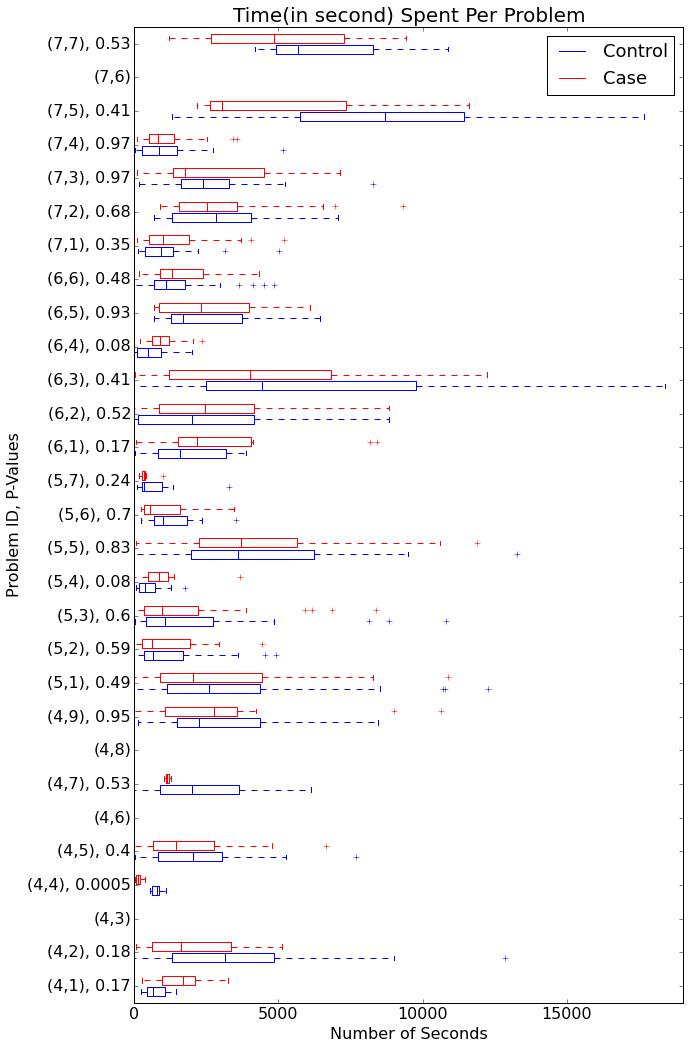

In [78]:
### Plot box plots
box_plots(problem_list, time_p_vals, control_feature, case_feature, 'Time(in second) Spent Per Problem', 'Number of Seconds', 19000)
savefig('../graphs/problem_time.png')

### 3. analysis per assignment
* For each assignment, find the number of tries(length of time) for control group with hint sent and case group with hint received.
* Remove case sessions where the student did not recieve any hint.
* Remove contol sessions where the student was not sent any hint (sent = if the student was in the case).

In [19]:
def feature_per_assignment(df, feature, problem_list, assignment_list, all_control=True):
    """
    For each assignment, find the number of tries(length of time) for control group with hint sent and case group with hint received.
    If [all_control] is false, only look at control students who has at least 1 hint sent.
    """
    ### for each assignment find the control and case features in the format of {pro_id:[feature list]}
    control_feature = defaultdict(list)
    case_feature = defaultdict(list)

    for student_id, row in df.iterrows():
        assignment_control = defaultdict(int)
        assignment_case = defaultdict(int)
        for prob in problem_list:
            if int(prob[0]) < 4: # Skip assignment 1, 2, and 3
                continue
            h_count_key = (prob[0], prob[1], 'hint_count')
            assign_key = (prob[0],'assign')
            feature_key = (prob[0],prob[1],feature)
            pro_key = (prob[0], prob[1])
            
            if row[feature_key]:
                if row[assign_key] == '0' and row[h_count_key] > 0: # control group with hints sent
                    assignment_control[prob[0]] += row[feature_key]
                elif row[assign_key] == '1' and row[h_count_key] > 0: # case group with hint received
                    assignment_case[prob[0]] += row[feature_key]
                    
        for assignment in assignment_list:
            if assignment_control[assignment]:
                control_feature[assignment].append(assignment_control[assignment])
            if assignment_case[assignment]:
                case_feature[assignment].append(assignment_case[assignment])

    return control_feature, case_feature

In [20]:
### Find number of tries per assignment
assignment_list = ['4', '5', '6', '7', '8']
control_feature, case_feature = feature_per_assignment(hint_feature_df, "tries", problem_list, assignment_list, all_control = False)
try_pros, try_control, try_case, try_p_vals = ttest(control_feature, case_feature, assignment_list)

4
control (size/mean/std): 53 32.7735849057 27.2947859486
case (size/mean/std): 45 34.4444444444 28.854081595
Ttest_indResult(statistic=-0.29113960499079217, pvalue=0.77157264987879359) 

5
control (size/mean/std): 90 83.2111111111 71.3763880105
case (size/mean/std): 89 73.9887640449 71.2000653929
Ttest_indResult(statistic=0.86053824798511069, pvalue=0.39065654980682851) 

6
control (size/mean/std): 56 53.8214285714 49.1848216798
case (size/mean/std): 52 51.9423076923 42.9608110606
Ttest_indResult(statistic=0.20881780105118347, pvalue=0.8349912252916003) 

7
control (size/mean/std): 56 40.4464285714 40.46555839
case (size/mean/std): 52 38.1346153846 30.7114541688
Ttest_indResult(statistic=0.32943875724935445, pvalue=0.74247415561768304) 

8
control (size/mean/std): 43 23.5581395349 18.5789357164
case (size/mean/std): 49 19.5102040816 9.30025772954
Ttest_indResult(statistic=1.3304370605880784, pvalue=0.18673561743085471) 



In [21]:
### Find length of time(in seconds) per assignment
assignment_list = ['4', '5', '6', '7', '8']
control_feature, case_feature = feature_per_assignment(hint_feature_df, "time_spent", problem_list, assignment_list, all_control = False)
time_pros, time_control, time_case, time_p_vals = ttest(control_feature, case_feature, assignment_list)

4
control (size/mean/std): 53 3765.81132075 3819.05653694
case (size/mean/std): 44 3338.13636364 3471.41957857
Ttest_indResult(statistic=0.56616162655378821, pvalue=0.57261892230999778) 

5
control (size/mean/std): 90 5714.62222222 4955.3150692
case (size/mean/std): 89 5208.85393258 4465.35849952
Ttest_indResult(statistic=0.71307813591393254, pvalue=0.47673647243860939) 

6
control (size/mean/std): 56 5547.64285714 6166.57704435
case (size/mean/std): 52 5532.69230769 6106.70871173
Ttest_indResult(statistic=0.012530475558035726, pvalue=0.99002594224039675) 

7
control (size/mean/std): 53 4704.45283019 5637.33822365
case (size/mean/std): 52 4270.21153846 4628.65282501
Ttest_indResult(statistic=0.42681602575052308, pvalue=0.67040414712833973) 

8
control (size/mean/std): 41 3119.14634146 3334.43888987
case (size/mean/std): 48 2515.70833333 1571.32699968
Ttest_indResult(statistic=1.1043654016984099, pvalue=0.27247970393939913) 



### 3. analysis per assignment with control average
* Find the number of tries(length of time) for each case student among the downstream problems.
* For the same set of downstream problems, find the control average.
* Therefore, case and control would be the same size.

In [35]:
def find_ave(df, feature, problem_list):
    """Find average tries for
    1. control students
    2. control students who would have got a hint
    """
    ### Average tries for all control students
    control_ave = defaultdict(float)
    
    ### Average tries for control students with a hint sent
    control_hint_ave = defaultdict(float)
    
    for pro in sorted(problem_list):
        if int(pro[0]) < 4: # skip assignment 1, 2, and 3
            continue
        hint_count_key = (pro[0], pro[1], 'hint_count')
        tries_key = (pro[0], pro[1], 'tries')
        assign_key = (pro[0], 'assign')
        prob_key = (pro[0], pro[1])
        feature_key = (pro[0], pro[1], feature)

        # all control students
        # select students who are in control and has more than 1 try.
        control_df = df[(df[assign_key] == '0') & (df[tries_key] > 0)]
        if len(control_df) != 0:
            control_ave[prob_key] = control_df[feature_key].mean()

        # control students with a hint sent
        # select students who are in control, with more than 1 try, and has hints sent
        control_hint_df = df[(df[assign_key] == '0') & (df[hint_count_key] > 0) & (df[tries_key] > 0)]
        if len(control_hint_df) != 0:
            control_hint_ave[prob_key] = control_hint_df[feature_key].mean()
            
    return control_ave, control_hint_ave

def feature_per_assignment_control_ave(df, feature, problem_list, assignment_list, downstream_problems, all_control=True):
    """
    For each assignment, find the number of tries(length of time) for downstream problems for case students.
    Also find the control average of the downstream problems for each case student.
    If [all_control] is false, only look at control students who has at least 1 hint sent.
    """
    ### for each assignment find the control and case features in the format of {pro_id:[feature list]}
    feature_diff = defaultdict(list)
    
    ### find control averages
    all_control_ave, control_hint_ave = find_ave(df, feature, problem_list)
    if all_control:
        control_ave = all_control_ave
    else:
        control_ave = control_hint_ave
        
    for student_id, row in df.iterrows():
        assignment_control = defaultdict(int)
        assignment_case = defaultdict(int)
        for prob in problem_list:
            if int(prob[0]) < 4: # Skip assignment 1, 2, and 3
                continue
            h_count_key = (prob[0], prob[1], 'hint_count')
            assign_key = (prob[0],'assign')
            feature_key = (prob[0],prob[1],feature)
            prob_key = (prob[0], prob[1])
                
            if row[assign_key] == '1' and row[h_count_key] == 0: # case group
                downstream = downstream_problems[student_id][prob[0]]
                if downstream: # has at least one hint in assignment pro[0]                    
                    if prob[1] in downstream and \
                    row[h_count_key] == 0 and \
                    row[feature_key] and \
                    control_ave[prob_key]:
                        assignment_case[prob[0]] += row[feature_key]
                        assignment_control[prob[0]] += control_ave[prob_key]
        for assignment in assignment_list:
            if assignment_case[assignment] and assignment_control[assignment]:
                feature_diff[assignment].append(assignment_case[assignment] - assignment_control[assignment])

    return feature_diff

def one_sample_ttest(feature_diff, problem_list):
    """
    perform t-test
    """
    p_vals = []
    for prob in problem_list:
        diff = feature_diff[prob]
        if diff:
            stat_values = stats.ttest_1samp(diff, 0)
            p_vals.append(stat_values[1])
            print 'Assignment', prob
            print 'Size', len(diff)
            print 'Mean', np.mean(diff)
            print 'Std', np.std(diff)
            print 'P-Value', stat_values[1], '\n'
            #print "{0} & {1:.3f} & {2:.3f} & {3:.3f} & {4:.3f} ".format(len(case_pro), np.mean(case_pro)/60., np.std(case_pro)/60., stat_values[1], diff/60.)
    return p_vals

In [40]:
### Find number of tries per assignment
assignment_list = ['4', '5', '6', '7']
feature_diff = feature_per_assignment_control_ave(hint_feature_df, 'tries', problem_list, assignment_list, downstream_problems, all_control = False)
try_p_vals = one_sample_ttest(feature_diff, assignment_list)

Assignment 4
Size 43
Mean -22.2348837209
Std 26.8253059431
P-Value 3.16085352015e-06 

Assignment 5
Size 81
Mean -43.1282792919
Std 35.5089178111
P-Value 2.05836032749e-17 

Assignment 6
Size 64
Mean -19.9555938521
Std 29.9438792567
P-Value 1.64063722202e-06 

Assignment 7
Size 55
Mean -86.785404538
Std 39.3924859809
P-Value 2.25085296268e-22 



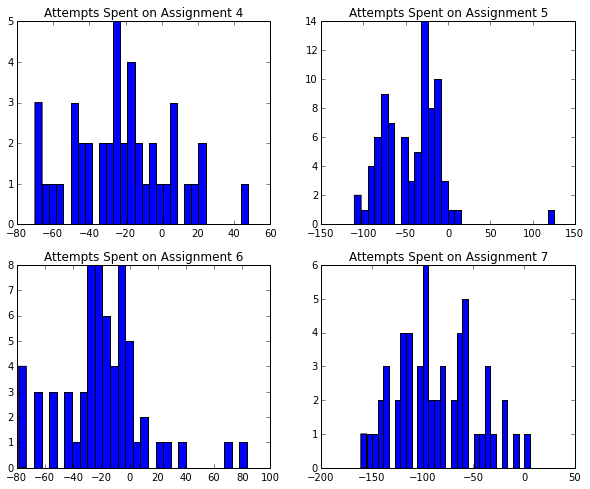

In [14]:
assignment_list = ['4', '5', '6', '7']
fig, axs = plt.subplots(2,2,figsize=(10,8))
plt.figure(figsize=(20,25))
axs = axs.flatten()
for i in range(len(assignment_list)):
    a = assignment_list[i]
    axs[i].hist(feature_diff[a], bins=30)
    axs[i].set_title("Attempts Spent on Assignment " + a)
plt.savefig('../graphs/assignment_tries_downstream.png', bbox_inches='tight')

In [41]:
### Find number of time spent per assignment
assignment_list = ['4', '5', '6', '7']
feature_diff = feature_per_assignment_control_ave(hint_feature_df, "time_spent", problem_list, assignment_list, downstream_problems, all_control = False)
time_p_vals = one_sample_ttest(feature_diff, assignment_list)

Assignment 4
Size 41
Mean -833.087465615
Std 2983.0830409
P-Value 0.08498312002 

Assignment 5
Size 62
Mean -1989.48083283
Std 1887.72462708
P-Value 1.76119273356e-11 

Assignment 6
Size 58
Mean -1396.85220266
Std 3850.47439974
P-Value 0.00821313772505 

Assignment 7
Size 53
Mean -5438.15861449
Std 5671.40881219
P-Value 6.77326226776e-09 



In [42]:
all_control_ave, control_hint_ave = find_ave(hint_feature_df, 'time_spent', problem_list)
a_ave = defaultdict(float)
a_count = defaultdict(int)
for a in all_control_ave:
    a_ave[a[0]] += all_control_ave[a]
    a_count[a[0]] += 1

for a in a_ave:
    a_ave[a] = a_ave[a]/a_count[a]
a_ave

defaultdict(float,
            {'4': 1035.2288759971734,
             '5': 1068.2370184636616,
             '6': 1610.5305924468491,
             '7': 1886.6402754800636,
             '8': 915.19663196514557})

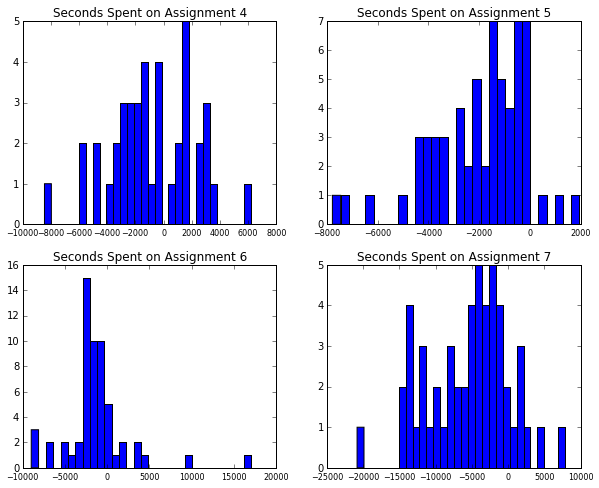

In [19]:
assignment_list = ['4', '5', '6', '7']
fig, axs = plt.subplots(2,2,figsize=(10,8))
plt.rc('xtick', labelsize=5)
axs = axs.flatten()
for i in range(len(assignment_list)):
    a = assignment_list[i]
    axs[i].hist(feature_diff[a], bins=30)
    axs[i].set_title("Seconds Spent on Assignment "+a)
plt.savefig('../graphs/assignment_time_downstream.png', bbox_inches='tight', pad_inches=0.2)